In [1]:
# Подключаем библиотеки
import os

if os.getcwd().endswith("experiment_notebooks"):
    os.chdir("..")

from compiled_wrapper import scidi_wrapper

import pandas
import numpy as np
import json
import random
import time 
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Загружаем данные с одинарным шумом
data = pandas.read_csv('test_data/numbers/digits+noise.csv', header=None)
data = data[data.columns[:-1]]
# Преобразуем в строку (оболочка работает пока только со строковым представлением)
str_data = data.values.astype(str)
print str_data[:5]

[['6' '2' '2' '7' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1' '1' '3' '5' '8'
  '1' '3' '7' '4' '4' '6']
 ['6' '2' '2' '7' '5' '1' '1' '8' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1'
  '1' '3' '7' '4' '4' '6']
 ['6' '2' '2' '7' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1'
  '1' '3' '7' '8' '4' '6']
 ['6' '2' '2' '7' '5' '1' '1' '3' '8' '1' '1' '3' '5' '1' '1' '3' '5' '1'
  '1' '3' '7' '4' '4' '6']
 ['6' '2' '8' '7' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1' '1' '3' '5' '1'
  '1' '3' '7' '4' '4' '6']]


In [13]:
# Тайлы для визуализации объектов
features = [[[0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],],
            [[1, 1, 1, 1, 1],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],],
            [[0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],],
            [[0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0],
             [1, 1, 1, 1, 1],],
            [[1, 0, 0, 0, 0],
             [1, 0, 0, 0, 0],
             [1, 0, 0, 0, 0],
             [1, 0, 0, 0, 0],
             [1, 0, 0, 0, 0],],
            [[0, 0, 0, 0, 1],
             [0, 0, 0, 1, 0],
             [0, 0, 1, 0, 0],
             [0, 1, 0, 0, 0],
             [1, 0, 0, 0, 0],],
            [[1, 0, 0, 0, 0],
             [0, 1, 0, 0, 0],
             [0, 0, 1, 0, 0],
             [0, 0, 0, 1, 0],
             [0, 0, 0, 0, 1],],
            [[1, 0, 1, 0, 1],
             [0, 1, 0, 1, 0],
             [1, 0, 1, 0, 1],
             [0, 1, 0, 1, 0],
             [1, 0, 1, 0, 1],],
            [[-1, 0, -1, 0, -1],
             [0, -1, 0, -1, 0],
             [-1, 0, -1, 0, -1],
             [0, -1, 0, -1, 0],
             [-1, 0, -1, 0, -1],]]

# Функция для визуализации объекта
def getVisualizationMatrix(obj):
    obj_img = np.empty((0,20))
    for i in range(6):
        current_raw = np.empty((5,0))
        for j in range(4):
            current_raw = np.concatenate((current_raw, np.array(features[int(obj[i*4 + j]) - 1])), axis = 1)
        obj_img = np.concatenate((obj_img, current_raw), axis = 0)
    return obj_img 
            

In [54]:
# Вспомогательная функция для генерации подвыборки и шума

def make_sample_with_noise_elements(data, sample_size = -1, noise_elements_count = 0):
    if sample_size >= 0:
        inds = np.random.choice(range(len(data)), sample_size)
        sample = data[inds]
    else:
        sample = data
    
    noise_data = []
    
    for j in range(noise_elements_count):
        current_element = []
        for i in range(data.shape[1]):    
            current_element.append(str(random.randint(1, 8)))
        noise_data.append(current_element)
    
    noise_data = np.array(noise_data)
    
    if noise_elements_count > 0:
        sample_with_noise = np.concatenate((sample, noise_data))
        return sample_with_noise
    
    return sample

# Вспомогательная функция для обработки естественных классов
def mapToNoNoise(item):
    item = item.split("|")
    item = [int(i) if len(i) > 0 else '8' for i in item]
    if len(item) > 0:
        return min(item)
    return 0

# Вспомогательная функция, преобразует правило из строки в список tuple
def ruleToPredArray(rule):
    rule = rule.replace(' not ', '-')
    preds = rule.split()
    preds = filter(lambda x : '=' in x and not '=>' in x, preds)
    pos_and_val = [(int(p.split('=')[0]), int(p.split('=')[1])) for p in preds]
    return pos_and_val

# Функция для создания объекта из правила в виде строки
def generateObjFromRule(rule):
    obj = ['8'] * 24
    preds = ruleToPredArray(rule)
    for pred in preds:
        if pred[1] >= 0:
            obj[pred[0] - 1] = str(pred[1])
        else:
            val = -1 * pred[1]
            choices = set(range(1, 9)) - set([val])
            obj[pred[0] - 1] = str(np.random.choice(list(choices)))
    return obj

In [40]:
def plotIdeals(ideals):
    from matplotlib import cm
    denoised_classes = map(lambda z: tuple(map(lambda x: mapToNoNoise(x), z)), ideals)
    unique_classes = list(set(denoised_classes))

    width =  4
    height = int ((len(unique_classes) * 1.0 - 1) / width) + 1 

    for j in range(0, height):
        plt.figure(figsize = (16, 5))
        for i in range(width):
            if i + width * j >= len(unique_classes):
                break
            img = getVisualizationMatrix(unique_classes[i + width * j])
            plt.subplot(1, width, i + 1)
            plt.imshow(img, cmap = cm.Paired)

        plt.show()
        
def makeObjectsFromIdeals(ideals):
    denoised_classes = map(lambda z: tuple(map(lambda x: mapToNoNoise(x), z)), ideals)
    objs = map(lambda x: map(str, list(x)), denoised_classes)
    return objs

In [65]:
sw = scidi_wrapper.ScidiWrapper()

# Загрузим правила. Данные правила были получены на объектах с пропусками и шумом
f = open("test_data/numbers/rules.txt", 'r')
rules = f.readlines()
f.close()

rules = map(lambda x: x[:-1], rules)

# В качестве обучающей выборки будем использовать объекты с пропусками и 1000-й шумовых
noised_data = make_sample_with_noise_elements(str_data, noise_elements_count = 1000)
sw.setData(str_data)
sw.setRulesFromStringVector(rules)

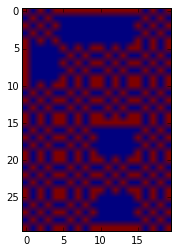

In [66]:
# Возьмем правила без отрицания
rules_without_not = filter(lambda x: not "not" in x, rules)
rule = '2=2 & 3=2 & 15=2 & 23=4 => 5=5'
obj = generateObjFromRule(rule)

plt.imshow(getVisualizationMatrix(obj))
plt.show()

Iteration 0
(('6|8|', '2|', '2|', '7|8|', '5|', '1|8|', '1|8|', '8|', '8|', '8|4|', '8|4|', '8|', '8|', '2|8|', '2|', '8|', '8|', '1|8|', '1|8|', '3|8|', '7|8|', '8|4|', '4|', '6|8|'),)


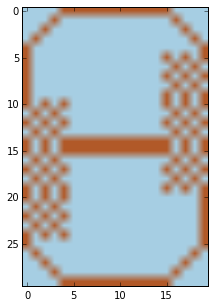

Iteration 1
(('6|', '2|', '2|', '7|', '5|', '1|', '1|', '3|8|', '8|', '4|', '4|', '8|', '8|', '2|', '2|', '8|', '8|', '1|', '1|', '3|', '7|', '4|', '4|', '6|'),)


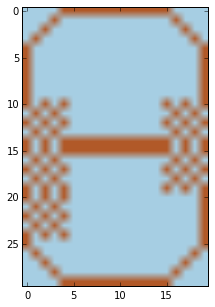

Iteration 2
(('6|', '2|', '2|', '7|', '5|', '1|', '1|', '3|', '7|8|', '4|', '4|', '8|', '8|', '2|', '2|', '8|', '8|', '1|', '1|', '3|', '7|', '4|', '4|', '6|'),)


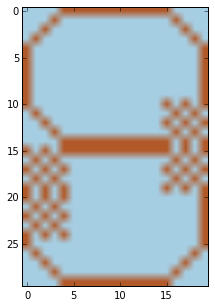

Iteration 3
(('6|', '2|', '2|', '7|', '5|', '1|', '1|', '3|', '7|', '4|', '4|', '8|', '8|', '2|', '2|', '8|', '8|', '1|', '1|', '3|', '7|', '4|', '4|', '6|'),)


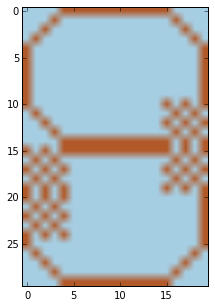

In [67]:
old_objs = [obj]
for iter_num in range(10):
    print "Iteration", iter_num
    ideals = sw.getIdealsFromNewData(old_objs)
    print ideals
    plotIdeals(ideals)
    
    new_objs = makeObjectsFromIdeals(ideals)
    if old_objs == new_objs:
        break
    else:
        old_objs = new_objs

5=5 & 8=5 & 15=3 => 1=5


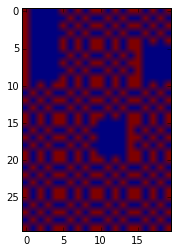

Iteration 0
(('5|', '1|8|', '3|8|', '5|8|', '5|', '1|8|', '3|8|', '5|', '5|8|', '8|4|', '8|', '5|8|', '2|8|', '1|8|', '3|', '5|8|', '8|', '8|', '3|8|', '5|8|', '1|8|', '8|', '3|8|', '5|8|'),)
[['5', '8', '8', '8', '5', '8', '8', '5', '8', '8', '8', '8', '8', '8', '3', '8', '8', '8', '8', '8', '8', '8', '8', '8']]


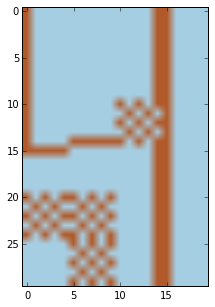

Iteration 1
(('5|', '1|', '3|', '5|', '5|', '1|', '3|', '5|', '5|', '4|', '3|8|', '5|', '2|', '1|', '3|', '5|', '1|8|', '1|8|', '3|', '5|', '1|', '1|8|', '3|', '5|'),)
[['5', '1', '3', '5', '5', '1', '3', '5', '5', '4', '8', '5', '2', '1', '3', '5', '8', '8', '3', '5', '1', '8', '3', '5']]


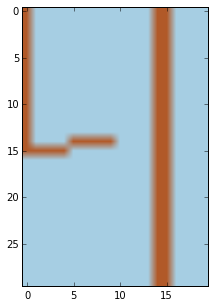

Iteration 2
(('5|', '1|', '3|', '5|', '5|', '1|', '3|', '5|', '5|', '4|', '3|', '5|', '2|', '1|', '3|', '5|', '1|', '1|', '3|', '5|', '1|', '1|', '3|', '5|'),)
[['5', '1', '3', '5', '5', '1', '3', '5', '5', '4', '3', '5', '2', '1', '3', '5', '1', '1', '3', '5', '1', '1', '3', '5']]


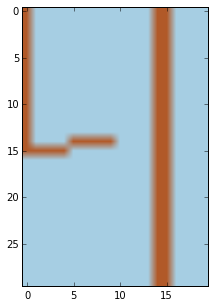

In [73]:
rule = rules_without_not[1000]
print rule
obj = generateObjFromRule(rule)
old_objs = [obj]

plt.imshow(getVisualizationMatrix(obj))
plt.show()

for iter_num in range(10):
    print "Iteration", iter_num
    ideals = sw.getIdealsFromNewData(old_objs)
    print ideals
    print old_objs
    plotIdeals(ideals)
    
    new_objs = makeObjectsFromIdeals(ideals)
    if old_objs == new_objs:
        break
    else:
        old_objs = new_objs